<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study an integral

**Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points**

In [ ]:
%%writefile task_7.py

import os
import time
import numpy as np

from PIL import Image
from mpi4py import MPI

#function
def f(x):
    #return (1 / 10) * (np.log(x) / 2) ** np.sin(x)
    return ((4*(x**2) + 1)**2) / (x**3)

#indefinite integral
def g(x):
    return -1/(2*(x**2)) + 8*(x**2) + 8*np.log(x)

def trap_integral(samples):
    y = f(samples)
    y_right = y[1:] 
    y_left = y[:-1] 
    dx = (samples[-1] - samples[0])/(samples.size)
    return (dx/2) * np.sum(y_right + y_left)

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False

LOWER_BOUND = 1
UPPER_BOUND = 15
LINSPACE_SIZE = 100_000_000

samples = None
array_size = None

if IS_ROOT:
    samples = np.linspace(LOWER_BOUND, UPPER_BOUND, num=LINSPACE_SIZE, dtype=float)
    array_size = samples.size
    
array_size = comm.bcast(array_size, root=0)
num_data_per_rank = array_size // size

if IS_ROOT:
    num_data_per_rank =  array_size - (num_data_per_rank * (size - 1))

received = np.empty(num_data_per_rank, dtype=float)
sendcounts = np.array(comm.gather(num_data_per_rank, 0))

comm.Scatterv((samples, sendcounts), received, root=0)
received_calc = trap_integral(received)

answer = comm.reduce(received_calc, op=MPI.SUM, root=0)

Overwriting task_7.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from task_7 import *
from matplotlib.patches import Polygon

**Compute the value analytically**

Find the integral of the function $$f(x) = \frac{(4x^2+1)^2}{x^3}$$ in limits $[1,15]$:
$$\int_{1}^{15} \frac{(4x^2+1)^2}{x^3}dx = \int_{1}^{5} \frac{16x^4+8x^2+1}{x^3} = \int_{1}^{5} 16x + \frac{8}{x} + \frac{1}{x^3}\,dx = \left(8x^2+8lnx-\frac{1}{2x^2}\right) \Big|_1^{15} = 1814.2$$

In [ ]:
analytical_ans = 1814.2

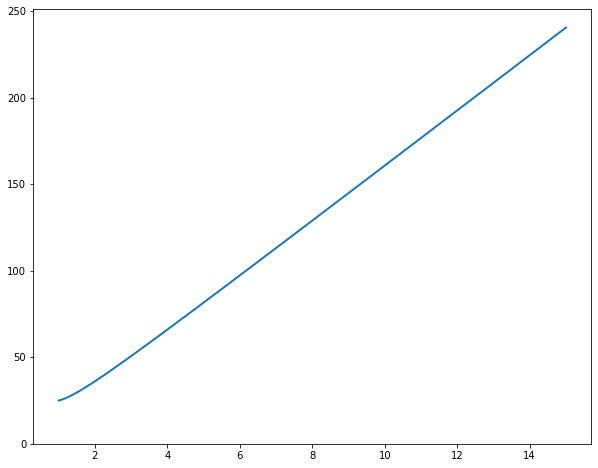

In [ ]:
a, b = 1, 15  # integral limits
x = np.linspace(1, 15, 1000)
y = f(x)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, linewidth=2)
ax.set_ylim(bottom=0)
plt.show()

**Compute the integral using trapezoidal rule**

In [ ]:
np.trapz(f(x), x=x)

1814.1623588244765

**Plot integration error vs the discretization size**

In [ ]:
quant_size = np.arange(1, 10_000, dtype=int)

squared_error = np.empty(quant_size.size, dtype=float)
quant_steps = np.empty(quant_size.size, dtype=float)

for i, size in enumerate(quant_size):
    samples, quant_step = np.linspace(1, 15, num=size, retstep=True)
    squared_error[i] = (analytical_ans - trap_integral(samples)) ** 2
    quant_steps[i] = quant_step

Text(0.5, 0.98, 'Integration error vs discretization step')

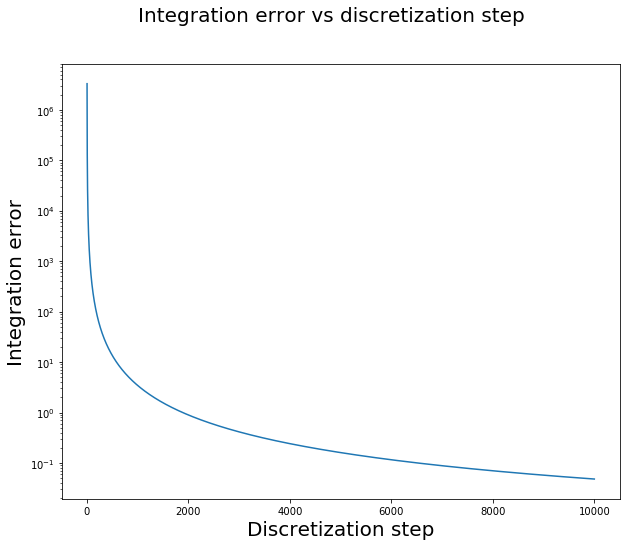

In [ ]:
plt.figure(figsize=(10, 8))
plt.semilogy(quant_size, squared_error)
plt.xlabel('Discretization step', fontsize=20)
plt.ylabel('Integration error', fontsize=20)
plt.suptitle('Integration error vs discretization step', fontsize=20)

**Plot the speedup vs number of processors**

In [ ]:
time_arr = []
processes = range(1, 12)
for i in processes:
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_7.py
    time_arr.append(t.best)

1 process(es)
	3.38 s ± 8.12 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	2.3 s ± 21.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	2 s ± 3.09 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	1.82 s ± 24.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
5 process(es)
	1.76 s ± 53.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 process(es)
	1.67 s ± 8.69 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7 process(es)
	1.62 s ± 43.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8 process(es)
	1.58 s ± 9.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
9 process(es)
	1.6 s ± 21 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
10 process(es)
	1.56 s ± 14.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
11 process(es)
	

Text(0.5, 0.98, 'SpeedUp vs Num of processes')

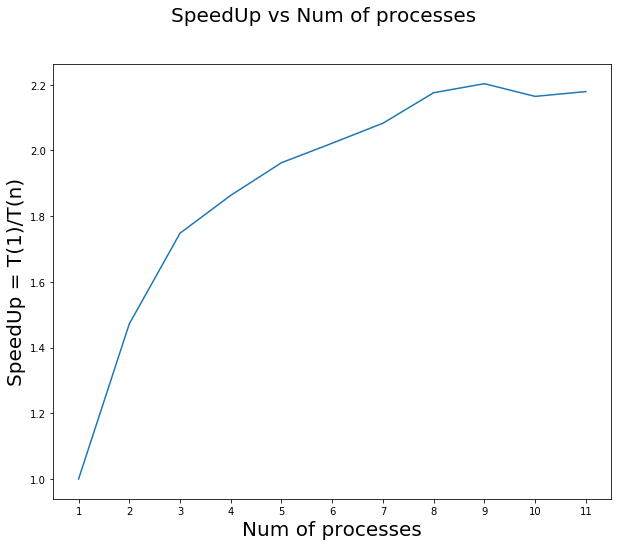

In [ ]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.suptitle('SpeedUp vs Num of processes', fontsize=20)